# Tarea 1
## Clemente Wacquez
---


### Pregunta 1
El cuaderno compilado se encuentra adjunto como `ejecucion.ipynb`. Se utilizaron 20.000 registros y $k=7$

---

### Pregunta 2 
El código presentado no tiene ninguna implementación de paralelismo. Esto puede deducirse dado que python no puede realizar paralelismo con sus librerias estándar y no se importa ninguna librería adicional que permita realizar paralelismo en el código.

---

### Pregunta 3
Copiamos las celdas que nos permiten generar los datos

In [1]:
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
from sklearn.datasets import make_blobs
n_points = 20_000
n_clusters = 3
np.random.seed(0)
dataset, _ = make_blobs(n_samples=n_points, n_features=2, centers=n_clusters)
print("Created a dataset that represents", n_clusters, "clusters in", dataset.shape[1], "dimensions.")

Created a dataset that represents 3 clusters in 2 dimensions.


In [3]:
k = 7
centers = np.zeros([k, 2])
for c in range(k):
    centers[c,0] = float(c+1)/(k+1)
    centers[c,1] = 0.0

max_iterations = 1000

A continuación, definiremos dos funciones: `k_medidas` y `k_medidas_numpy`, la primera corresponde a la implementación del algoritmo de $k$-medidas que se entregó de ejemplo y la segunda la reimplementación utilizando funciones de la librería `numpy` . Las porciones con código modificado se encuentran comentadas con `##`.

In [4]:
def k_medias(data, k):
    
    centers = np.zeros([k, 2])
    for c in range(k):
        centers[c,0] = float(c+1)/(k+1)
        centers[c,1] = 0.0
    
    max_iterations = 1000
    
    # store the history of centers and clusters
    history_of_centers = [centers]
    history_of_clusters = []
    
    for iteration in range(max_iterations):
        
        old_centers = history_of_centers[-1]
    
        # assignment step
        cluster = np.zeros(n_points, dtype='int')
        for p in range(n_points):
            minimum_distance = np.inf
            nearest_cluster = None
            for c in range(k):
                distance_to_cluster_c = np.sqrt((data[p,0] - old_centers[c,0])**2 + (data[p,1] - old_centers[c,1])**2)
                if distance_to_cluster_c < minimum_distance:
                    minimum_distance = distance_to_cluster_c
                    nearest_cluster = c
            cluster[p] = nearest_cluster
        history_of_clusters.append(cluster)
        
        # check convergence
        if iteration > 0:
            clusters_changed = False
            for p in range(n_points):
                if history_of_clusters[-1][p] != history_of_clusters[-2][p]:
                    clusters_changed = True
            if not clusters_changed:
                print("Converged in", iteration, "iterations.\n")
                break
    
        # update step
        number_of_points_in_cluster = np.zeros(k, dtype='int')
        sum_of_locations = np.zeros([k, 2], dtype='float')
        for p in range(n_points):
            number_of_points_in_cluster[cluster[p]] += 1
            sum_of_locations[cluster[p], :] += data[p, :]
        new_centers = np.zeros([k, 2], dtype='float')
        for c in range(k):
            new_centers[c,0] = sum_of_locations[c,0] / number_of_points_in_cluster[c]
            new_centers[c,1] = sum_of_locations[c,1] / number_of_points_in_cluster[c]
        history_of_centers.append(new_centers)
    
    if iteration == max_iterations-1:
        print("The algorithm did not converge in", max_iterations, "iterations.")

    else:
        return history_of_clusters[-1], history_of_centers[-1]

In [5]:
def k_medias_numpy(data, k):
    
    centers = np.zeros([k, 2])
    for c in range(k):
        centers[c,0] = float(c+1)/(k+1)
        centers[c,1] = 0.0
    
    max_iterations = 1000
    
    # store the history of centers and clusters
    ## Cambiamos los tipos de los historiales a np.array
    history_of_centers = np.array([centers])
    history_of_clusters = np.empty((0, n_points))
    
    for iteration in range(max_iterations):
        
        old_centers = history_of_centers[-1]
    
        # assignment step
        ## Calculamos las distancias que hay entre los registros y los centros utilizando cdist
        dist_matrix = cdist(data, old_centers)
        i = 0
        cluster = np.zeros(n_points, dtype='int')
        for row in dist_matrix:
            ## Utilizamos np.argmin para obtener el índice del centro más cercano 
            c = np.argmin(row)
            cluster[i] = c
            i += 1
        ## Añadimos el cluster al historial utilizando np.vstack
        history_of_clusters = np.vstack([history_of_clusters, cluster])
    
        if iteration > 0:
            clusters_changed = False
            ## Chequeamos si los clusters cambiaron utilizando np.array_equal
            if not np.array_equal(history_of_clusters[-1], history_of_clusters[-2]):
                clusters_changed = True
            if not clusters_changed:
                print("Converged in", iteration, "iterations.\n")
                break
    
        # update step
        ## Eliminamos el loop utilizando la función np.mean y el hecho que el arreglo `cluster==center`
        ## nos entregará los valores en el data que pertenecen al centro `center`
        new_centers = np.array([np.mean(data[cluster == center], axis=0) for center in range(k)])
        history_of_centers = np.append(history_of_centers, [new_centers], axis=0)
    
    if iteration == max_iterations-1:
        print("The algorithm did not converge in", max_iterations, "iterations.")
    else:
        return history_of_clusters[-1], history_of_centers[-1]

---

### Pregunta 4
#### Comparación de tiempos
Sin `numpy`:

In [6]:
%%time
k_medias(dataset, k)

Converged in 69 iterations.

CPU times: user 51.2 s, sys: 24.8 ms, total: 51.2 s
Wall time: 51.4 s


(array([5, 2, 0, ..., 6, 6, 6], shape=(20000,)),
 array([[-2.42643815,  3.16739782],
        [-0.4525531 ,  4.1582162 ],
        [-1.12449342,  2.0582954 ],
        [ 1.40197533,  4.92862   ],
        [ 1.45500616,  0.35161267],
        [ 1.41441328,  2.92325992],
        [ 2.9391587 ,  1.05490536]]))

Con `numpy`

In [7]:
%%time
k_medias_numpy(dataset, k)

Converged in 69 iterations.

CPU times: user 6.48 s, sys: 59.4 ms, total: 6.54 s
Wall time: 6.59 s


(array([5., 2., 0., ..., 6., 6., 6.], shape=(20000,)),
 array([[-2.42643815,  3.16739782],
        [-0.4525531 ,  4.1582162 ],
        [-1.12449342,  2.0582954 ],
        [ 1.40197533,  4.92862   ],
        [ 1.45500616,  0.35161267],
        [ 1.41441328,  2.92325992],
        [ 2.9391587 ,  1.05490536]]))

a) El código no corre ninguna parte en paralelo, incluso las funciones de `numpy` y `scipy` utilizadas corren en un solo hilo. [referencia](google.com).

b) La diferencia de tiempos observadas en el sistema en que se corrió este código fue de 42.35 segundos. La implementación con `numpy` fué más de 7 veces más rápida que la original.

---

### Pegunta 5
Definimos una función para calcular la dispersión dado el output de las funciones definidas en las celdas anteriores. Se asume que 

In [8]:
def dispersion(data, clusters, centers):
    pass

In [13]:
def calc_dispersion(data, k):
    print("k =", k, end=": ")
    cluster, centers = k_medias_numpy(data, k)
    dispersion = 0.0
    for i in range(centers.shape[0]):
        dispersion += np.sum( np.linalg.norm( data[cluster==i, :] - centers[i,:], axis=1 ) )
    return dispersion

Ahora graficamos la dispersión para distintos valores de $k$:

k = 2: Converged in 15 iterations.

k = 3: Converged in 11 iterations.

k = 4: Converged in 74 iterations.

k = 5: Converged in 84 iterations.

k = 6: Converged in 109 iterations.

k = 7: Converged in 69 iterations.

k = 8: Converged in 117 iterations.

k = 9: Converged in 115 iterations.

k = 10: Converged in 96 iterations.

k = 11: Converged in 107 iterations.

k = 12: Converged in 84 iterations.

k = 13: Converged in 79 iterations.

k = 14: Converged in 89 iterations.

k = 15: Converged in 135 iterations.

k = 16: Converged in 133 iterations.

k = 17: Converged in 100 iterations.

k = 18: Converged in 130 iterations.

k = 19: Converged in 110 iterations.

k = 20: Converged in 62 iterations.

k = 21: Converged in 88 iterations.

k = 22: Converged in 99 iterations.

k = 23: Converged in 111 iterations.

k = 24: Converged in 93 iterations.

k = 25: Converged in 85 iterations.



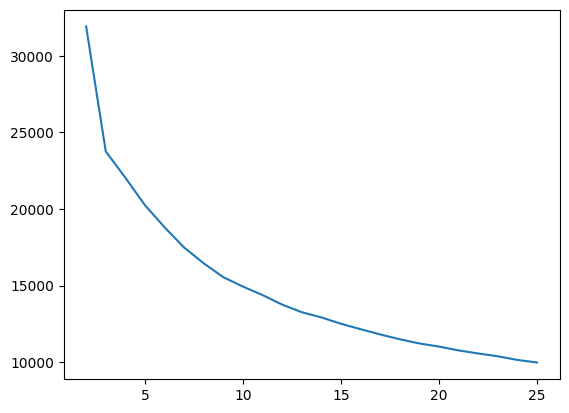

In [14]:
import matplotlib.pyplot as plt
x = [i for i in range(2, 26)]
y = [calc_dispersion(dataset, i) for i in range(2, 26)]

plt.plot(x,y)
plt.show()